# HW4 - Logistic Regression
4조(박예진, 임동욱, 조정윤, 홍정빈)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics

from numba import jit

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
titanic_df = pd.read_csv("./train_titanic.csv")

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 1. 전처리

## 1-1. 범주형 처리하기

### 1-1-1. Name 전처리 & 피처 엔지니어링

In [5]:
# 이름 안에 있는 작위(?)들을 . 을 기준으로 정규식으로 추출한 후 Title 컬럼을 새로 만들어 거기에 담는다.
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [6]:
titanic_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [7]:
# 성별에 따른 작위의 수도 확인한다.
# -> 나중에 Mr, Miss, Mrs 중 무엇의 오타인지 확인하기 위함
name_sex = titanic_df
name_sex['Title'] = name_sex.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(name_sex['Title'], name_sex['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [8]:
# 거의 유니크한 작위들은 'Rare'로 통일하고
# Mlle, Ms, Mme는 오타인 것 같아 수정한다.
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')


In [9]:
# 만들어진 5개의 작위들에 번호를 부여한다.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)

In [10]:
# Name은 제거한다.
titanic_df = titanic_df.drop(['Name'], axis=1)

### 1-1-2. Sex 0과 1로 매핑

In [11]:
titanic_df.Sex = titanic_df.Sex.map({'male': 0, 'female': 1})

### 1-1-3. Embarked 0과 1로 매핑

In [12]:
ports = pd.get_dummies(titanic_df.Embarked, prefix='Embarked')

In [13]:
titanic_df = titanic_df.join(ports)
titanic_df.drop(['Embarked'], axis=1, inplace=True)

### 1-1-4. PassengerId, Ticket, Cabin 제거

In [14]:
titanic_df = titanic_df.drop(['PassengerId'], axis=1)
titanic_df = titanic_df.drop(['Ticket'], axis=1)
titanic_df = titanic_df.drop(['Cabin'], axis=1)

In [15]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,1,0,0,1
1,1,1,1,38.0,1,0,71.2833,3,1,0,0
2,1,3,1,26.0,0,0,7.9250,2,0,0,1
3,1,1,1,35.0,1,0,53.1000,3,0,0,1
4,0,3,0,35.0,0,0,8.0500,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,5,0,0,1
887,1,1,1,19.0,0,0,30.0000,2,0,0,1
888,0,3,1,NaN,1,2,23.4500,2,0,0,1
889,1,1,0,26.0,0,0,30.0000,1,1,0,0


---

## 1-2. 연속형 처리하기

### 1-2-1. Age 전처리 & 피처 엔지니어링

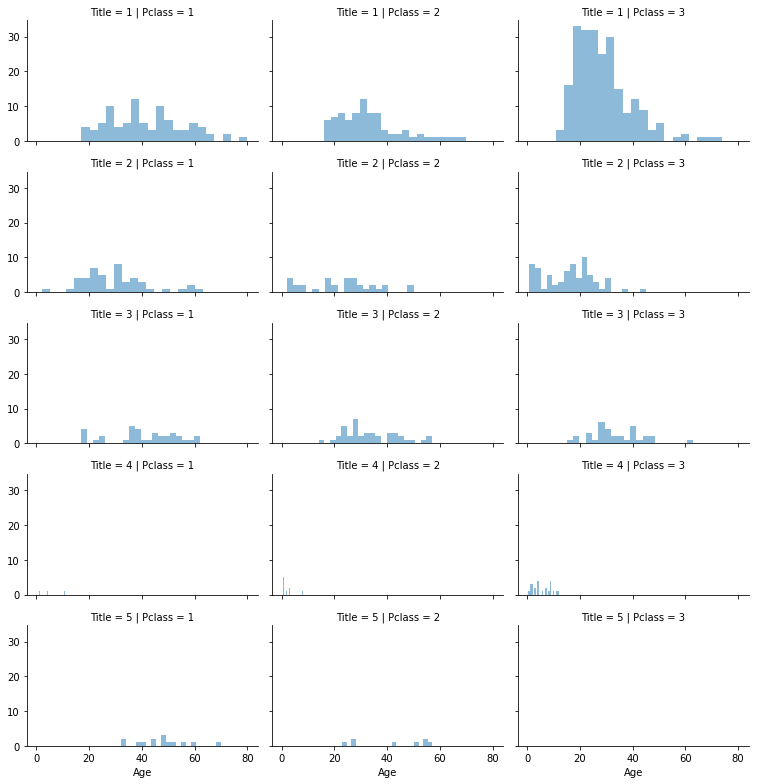

In [16]:
# Age의 null 값을 처리해야 한다.
# Pclass * Title과 Age 사이의 상관관계를 이용해 결측치를 채운다.

# 시각화
grid = sns.FacetGrid(titanic_df, row='Title', col='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [17]:
np.isnan(titanic_df.loc[888]['Age'])

True

In [18]:
titanic_df.loc[888]

Survived       0.00
Pclass         3.00
Sex            1.00
Age             NaN
SibSp          1.00
Parch          2.00
Fare          23.45
Title          2.00
Embarked_C     0.00
Embarked_Q     0.00
Embarked_S     1.00
Name: 888, dtype: float64

In [19]:
# 빈 age 리스트를 만들고 그 안에 Title과 Pclass에 따른 Age 값들 넣어주기.

age = [[[],[],[]], 
       [[],[],[]], 
       [[],[],[]], 
       [[],[],[]], 
       [[],[],[]]]

for i in range(0, len(titanic_df)):
    if np.isnan(titanic_df.loc[i]['Age']) == False :
        for t in range(1,6):
            for p in range(1,4):
                if (titanic_df.loc[i]['Title'] == t) & (titanic_df.loc[i]['Pclass'] == p):
                    age[t-1][p-1].append(titanic_df.loc[i]['Age'])


In [20]:
# 중앙값으로
age_median = [[[],[],[]], 
               [[],[],[]], 
               [[],[],[]], 
               [[],[],[]], 
               [[],[],[]]]

for i in range(0,5):
    for j in range(0,3):
        age_median[i][j].append(np.median(age[i][j]))

In [21]:
age_median

[[[40.0], [31.0], [26.0]],
 [[30.0], [24.0], [18.0]],
 [[40.0], [32.0], [31.0]],
 [[4.0], [1.0], [4.0]],
 [[48.5], [46.5], [nan]]]

In [22]:
# 평균값으로
age_mean = [[[],[],[]], 
           [[],[],[]], 
           [[],[],[]], 
           [[],[],[]], 
           [[],[],[]]]

for i in range(0,5):
    for j in range(0,3):
        age_mean[i][j].append(np.mean(age[i][j]))

In [23]:
age_mean

[[[41.58045977011494], [32.76829268292683], [28.724890829694324]],
 [[29.74468085106383], [22.560606060606062], [16.1231884057971]],
 [[40.4], [33.68292682926829], [33.515151515151516]],
 [[5.306666666666667], [2.2588888888888885], [5.350833333333334]],
 [[47.57142857142857], [42.0], [nan]]]

In [24]:
# age 리스트로 만든 평균값들을 원본 데이터의 결측값에 넣어주기.
# 데이터 수가 너무 적은 것은 중앙값보다는 평균값이 유리하다고 판단해서 전부 평균값으로 대체하기로 했다.
# (실제로 평균값을 넣었을 때 점수가 더 높다.)
for i in range(0, len(titanic_df)):
    if np.isnan(titanic_df.loc[i]['Age']) :
        for t in range(1,6):
            for p in range(1,4):
                if (titanic_df.loc[i]['Title'] == t) & (titanic_df.loc[i]['Pclass'] == p):
                    titanic_df.loc[i, 'Age'] = round(age_mean[t-1][p-1][0])  # 값을 넣을 때는 loc[i, 'Age'] 형태를 이용해야한다.


In [25]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Title       891 non-null    int64  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 58.4 KB


---
---

# 2. 모델링 - Logistic Regression

### Reference Link
- https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch03/ch03.ipynb#scrollTo=5AvXleRzvOQw
- https://www.dotnetlovers.com/Article/225/logistic-regression-explained
- https://ee227c.github.io/code/lecture24.html
- https://github.com/DrIanGregory/MachineLearning-LogisticRegressionWithGradientDescentOrNewton/blob/7381c7748899dad57d940c5db9482fc1841043e9/logisticRegression.py#L225

In [27]:
class Logistic:

    def __init__(self, alpha=0.01, maxIterations=100000, fitIntercept=True, optimisation="gradient_ascent"):
        self.alpha = alpha                  # learning rate (pdf 4)
        self.maxIterations = maxIterations  # 최대 반복횟수
        self.numIterations = 0              # 반복횟수 기록
        self.hasConverged = False          # 충분히 수렴 되었을 때 반복 종료
        self.fitIntercept = fitIntercept
        self.costHistory = [] 
        self.tolerance = tol=1e-7           # 허용오차값
        self.theta=[] 
        self.optimisation = optimisation    # gradient_ascent와 newton method 중 택 1


    def sigmoid_function(z):     # (pdf 16p)
        return 1 / (1 + np.exp(-z))

    
    def gradient_ascent(X,y,theta,alpha):  # (pdf 18p)
        z = np.dot(X, theta)
        p = Logistic.sigmoid_function(z)
        gradient = np.dot(X.T, (p - y)) / y.size   #log likelihood를 한 번 미분한 식(pdf 18p)
        theta -= alpha * gradient   # 파라미터(세타값) 업데이트
        return theta 

    
    def newton(X,y,theta,useRegulisation=False,regulisationParameter=0):  # (pdf 20p)
        z = np.dot(X, theta)
        p = Logistic.sigmoid_function(z)
        W = np.diag(p * (1 - p))
        hessian = X.T.dot(W).dot(X)   # hessian 행렬
        gradient = np.dot(X.T, (y - p))   #log likelihood를 한 번 미분한 식(pdf 18p)..... 왜 위 식이랑 다르지..?
        try:
            if useRegulisation:
                step = np.dot(np.linalg.inv(hessian + regulisationParameter * np.eye(theta)), grad)
            else:
                step = np.dot(np.linalg.inv(hessian), gradient)
        except np.linalg.LinAlgError:  #에러 발생한 경우에는 step=0으로 설정
            step=0 

        theta = theta + step # 가중치 업데이트

        return theta 

    
    # ↑ Logistic 관련 함수
# -------------------------------------------------------------------------------------------------------------------    
    # ↓ 모델 fit & predict 관련 함수
    
    
    def add_intercept(X): 
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def log_cost(self, X, y, theta):   # Logistic regression log 손실 함수.
        z = np.dot(X, theta)
        p = Logistic.sigmoid_function(z)
        return (-y * np.log(p) - (1 - y) * np.log(1 - p)).mean()  

    
    def fit(self, X, y):
        if self.fitIntercept:
            X = Logistic.add_intercept(X=X)

        self.theta = np.zeros(X.shape[1])   # weight 초기값 설정
        alpha=self.alpha 

        cost = self.log_cost(X, y, self.theta)   # cost 계산
        self.costHistory.append(cost)   # plotting시 사용할 초기 cost 값


        iterCount=0 
        while not self.hasConverged:
            # parameter 성능을 바꿔가면서 cost 값을 줄이기 위해 optimisation을 반복적으로 실행. 
            iterCount+=1     # optimisation 반복문에 사용할 counter


            # optimisation 방식에 따라 coefficient 업데이트 계산 단계를 다르게 실행
            if self.optimisation=="gradient_ascent":
                theta = Logistic.gradient_ascent(X,y,self.theta,self.alpha)
            elif self.optimisation=="newton":
                theta = Logistic.newton(X, y, self.theta)
            else:
                print('optimisation에는 gradient_ascent 혹은 newton을 넣어주세요')
                return 

            cost = self.log_cost(X,y, theta)      # cost 계산


            if iterCount>1:
            # 두번째 optimisation 계산 후, optimisation 종료를 확인하기 위해 사용.
                hasConverged = self.checkConvergence(self.costHistory[-1], cost, self.tolerance,iterCount) 
                # covergence tolerance에 도달하면 iteration 업데이트를 종료해야하는지 확인
                if hasConverged.hasConverged==True: 
                    self.numIterations = iterCount 
                    self.hasConverged == True
                    
            if iterCount < 2:
                self.theta = theta 
                self.costHistory.append(cost)   # Record the cost for plotting.
            else:
                if not (((self.optimisation == "newton") and (cost > self.costHistory[-1])) or (np.isnan(cost))) or iterCount<1:
                    # 뉴턴 방식은 수렴에 가까울수록 마지막 단계에서 좋지 않은 cost 값을 준다.
                    # 때문에, 마지막 세타값과 마지막 cost값을 저장하지 않고 바로 직전 것을 사용한다. 
                    self.theta = theta 
                    self.costHistory.append(cost)   # plotting을 위한 cost 값 저장


    def checkConvergence(self,previousCost, cost, tolerance, iterCount):
        # coefficients가 converge 되었는지 확인하는 함수
        # converge 되었으면 True를 반환
        costChange = np.abs(previousCost - cost)

        self.hasConverged=False 
        if (np.any(costChange < tolerance)): 
            self.hasConverged = True 
            
        # thresholds(최대 반복횟수)에 도달하지 않은 경우 반복문 계속 수행
        if (iterCount > self.maxIterations):
            self.hasConverged = True 


        if (self.optimisation == "newton"):
            if (np.isnan(cost)):
                # 뉴턴 방식은 수렴에 가까울수록 마지막 단계에서 좋지 않은 cost 값을 준다.
                # 때문에, 마지막 세타값과 마지막 cost값을 저장하지 않고 바로 직전 것을 사용한다. 
                self.hasConverged = True 
            elif (cost > previousCost):
                self.hasConverged = True 
        return self


    def predict_prob(X,theta,fitIntercept=True):
        if fitIntercept:
            X = Logistic.add_intercept(X=X)
        return Logistic.sigmoid_function(np.dot(X, theta))

    
    def predict(self, X, proba=False):
        pred = Logistic.predict_prob((X).round(), self.theta, self.fitIntercept)
        
        if proba == True: pass  # True로 설정하면 0 또는 1이 아닌 확률값 반환
        
        elif proba == False:   # 0 또는 1 값으로 바꿔주기
            for i in range(len(pred)):  
                if pred[i] < 0.5:
                    pred[i] = 0
                else :
                    pred[i] = 1  
                    
        return pred

In [ ]:
X = titanic_df.drop(['Survived'], axis=1)
Y = titanic_df.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2022)

## 3-1. Gradient Ascent

In [28]:
# optimisation="gradient_ascent" : 경사 상승법 사용
logit_model = Logistic(alpha=0.1, maxIterations=100000,fitIntercept=True, optimisation="gradient_ascent")
logit_model.fit(X_train, y_train) # 모델 적합
y_pred_ga = logit_model.predict(X_test) # 예측값 만들기

In [29]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_ga))  # gradient_ascent 방법은 시간이 약간 걸림
print("Precision:", metrics.precision_score(y_test, y_pred_ga))
print("Recall:", metrics.recall_score(y_test, y_pred_ga))
print("F1_score:", metrics.f1_score(y_test, y_pred_ga))

Accuracy: 0.7892376681614349
Precision: 0.8666666666666667
Recall: 0.4875
F1_score: 0.624


## 3-2. Newton Method

In [30]:
# optimisation="newton" : 뉴턴 방법 사용
logit_model = Logistic(alpha=0.1, maxIterations=100000,fitIntercept=True, optimisation="newton")
logit_model.fit(X_train, y_train) # 모델 적합
y_pred_nt = logit_model.predict(X_test) # 예측값 만들기

In [31]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_nt))
print("Precision:", metrics.precision_score(y_test, y_pred_nt))
print("Recall:", metrics.recall_score(y_test, y_pred_nt))
print("F1_score:", metrics.f1_score(y_test, y_pred_nt))

Accuracy: 0.8475336322869955
Precision: 0.8026315789473685
Recall: 0.7625
F1_score: 0.7820512820512822


---

## 3-3.  Newton Method의 결과를 0과 1 말고 probability 값으로 반환해보기

In [33]:
y_pred_proba = logit_model.predict(X_test, proba=True)

y_pred_proba_1 = []
y_pred_proba_0 = []
for i in range(len(y_pred_proba)):
    if y_pred_proba[i] >= 0.5 :
        y_pred_proba_1.append(y_pred_proba[i])
    else :
        y_pred_proba_0.append(y_pred_proba[i])

print(f'y_pred 전체 수 : {len(y_pred_proba)}',
      f'0.5 이상인 값의 수 : {len(y_pred_proba_1)}',
      f'0.5 미만인 값의 수 : {len(y_pred_proba_0)}', sep='\n')
print()
print(f'0.5 이상인 값의 평균 : {np.mean(y_pred_proba_1)} -> 1로 예측한 값들의 평균확률 : {round(np.mean(y_pred_proba_1)*100,2)}%',
      f'0.5 미만인 값의 평균 : {np.mean(y_pred_proba_0)} -> 0으로 예측한 값들의 평균확률 : {round(100-np.mean(y_pred_proba_0)*100,2)}%', sep='\n')
print()
print(f'1로 예측한 값들의 최소확률, 최대확률 : {round(np.min(y_pred_proba_1)*100,2)}%, {round(np.max(y_pred_proba_1)*100,2)}%',
      f'0으로 예측한 값들의 최소확률, 최대확률 : {round(100-np.max(y_pred_proba_0)*100,2)}%, {round(100-np.min(y_pred_proba_0)*100,2)}%', sep='\n')

y_pred 전체 수 : 223
0.5 이상인 값의 수 : 76
0.5 미만인 값의 수 : 147

0.5 이상인 값의 평균 : 0.7502273831003863 -> 1로 예측한 값들의 평균확률 : 75.02%
0.5 미만인 값의 평균 : 0.1636065896644827 -> 0으로 예측한 값들의 평균확률 : 83.64%

1로 예측한 값들의 최소확률, 최대확률 : 50.33%, 99.99%
0으로 예측한 값들의 최소확률, 최대확률 : 50.19%, 97.4%


<AxesSubplot:title={'center':'Density of 1'}, ylabel='Density'>

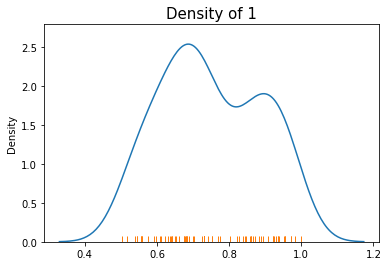

In [34]:
plt.title("Density of 1", size=15)
sns.kdeplot(x=y_pred_proba_1)
sns.rugplot(x=y_pred_proba_1)
# 생존한 사람(1)을 예측한다면 그래프가 1 방향으로 치우쳐져 있어야 좋지만,
# 우리 모델에서는 다소 0.5에 가깝게 치우쳐져 있다.

<AxesSubplot:title={'center':'Density of Not 1'}, ylabel='Density'>

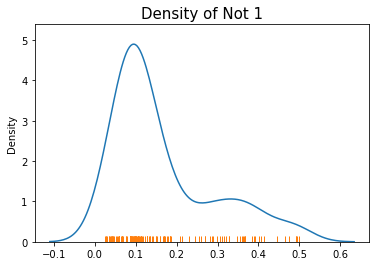

In [35]:
plt.title("Density of Not 1", size=15)
sns.kdeplot(x=y_pred_proba_0)
sns.rugplot(x=y_pred_proba_0)
# 사망한 사람(0)을 예측한다면 그래프가 0 방향으로 치우쳐져 있어야 좋으며,
# 우리 모델에서도 0에 가깝게 치우쳐져 있다.